# Удержание клиентов фитнес-центра 

Сеть фитнес-центров «Культурист-датасаентист» обратился к нам для разработки стратегии взаимодействия с пользователями на основе аналитических данных.Сети необходимо разобраться с проблемой оттока клиентов.  Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 
В нашем распоряжении будет множество анкет пользователей центра. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. Так, нам предствоит сделать следующее:
    
•	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

•	сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

•	проанализировать основные признаки, наиболее сильно влияющие на отток;

•	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

**o** выделить целевые группы клиентов;

**o** предложить меры по снижению оттока;

**o** определить другие особенности взаимодействия с клиентами.


В ходе решения кейса нам предстоит пройти следующие этапы:

**`Шаг 1. Загрузить данные`**

**`Шаг 2. Провести исследовательский анализ данных (EDA)`**

1) Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения (пригодится метод describe());

2) Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуемся методом groupby());

3) Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

4) Построим матрицу корреляций и отобразим её.


**`Шаг 3. Построить модель прогнозирования оттока клиентов`**

Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
1) Разобьем данные на обучающую и валидационную выборку функцией train_test_split().

2) Стандартизируем данные.

3) Обучим модель на train-выборке двумя способами:
*	логистической регрессией,
*	случайным лесом.

4)	Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?


**`Шаг 4. Сделать кластеризацию клиентов`**

**Отложим в сторону столбец с оттоком и проведем кластеризацию объектов (клиентов):**

1) Строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

2) Обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов. За число кластеров возьмем n=5.
3) Смотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

4) Строим распределения признаков для кластеров. Можно ли что-то заметить по ним?

5) Для каждого полученного кластера считаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

**`Шаг 5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами`**

# Шаг 1. Загружаем данные

Для работы с данными нам нужно импортировать библиотеки, которые понадобятся нам для дальнейшей работы.

In [24]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [25]:
#добавление класса для шрифта
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

Далее можем приступать к загрузке данных. Поместим датасет в переменную gym.

In [26]:
#загружаем данные
gym = pd.read_csv('/datasets/gym_churn.csv')

Посмотрим, что у нас получилось - выведем первые 5 строк датасета.

In [27]:
#выводим первые 5 строк датасета
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Согласно документации к данным в датасете 14 столбцев.

**Данные клиента за предыдущий до проверки факта оттока месяц:**

**1)** 	**`'gender'`** — пол;

**2)**	**`'Near_Location'`** — проживание или работа в районе, где находится фитнес-центр;

**3)**	**`'Partner'`** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

**4)**	**`'Promo_friends'`** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

**5)**	**`'Phone'`** — наличие контактного телефона;

**6)**	**`'Age'`** — возраст;

**7)**	**`'Lifetime'`** — время с момента первого обращения в фитнес-центр (в месяцах).


**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

**8)** **`'Contract_period'`** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

**9)** **`'Month_to_end_contract'`** — срок до окончания текущего действующего абонемента (в месяцах);

**10)** **`'Group_visits'`** — факт посещения групповых занятий;

**11)** **`'Avg_class_frequency_total'`** — средняя частота посещений в неделю за все время с начала действия абонемента;

**12)** **`'Avg_class_frequency_current_month'`** — средняя частота посещений в неделю за предыдущий месяц;

**13)** **`'Avg_additional_charges_total'`** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

**14)** **`'Churn'`** — факт оттока в текущем месяце.



Мы видим, что названия столбцев не соответствуют правилам хорошего стиля.

In [28]:
#приводим названия к нижнему регистру
gym.columns = gym.columns.str.lower()

# Шаг 2. Проводим исследовательский анализ данных (EDA)

Для начала получим общую информацию о датасете.

In [29]:
#получаем общую информацию о датасете
gym.info()
gym.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [30]:
#посмотрим на дубликаты
gym.duplicated().sum()

0

In [31]:
# отдельно посмотрим на доли клиентов с разными абонементами
gym['contract_period'].value_counts(normalize = True)

1     0.55175
12    0.24000
6     0.20825
Name: contract_period, dtype: float64

In [32]:
# отдельно посмотрим на доли клиентов с разными сроками действия абонемена
gym['month_to_end_contract'].value_counts(normalize = True)

1.0     0.55175
6.0     0.16125
12.0    0.13100
11.0    0.04525
5.0     0.03250
10.0    0.02050
9.0     0.01825
4.0     0.01450
8.0     0.00950
7.0     0.00625
3.0     0.00575
2.0     0.00350
Name: month_to_end_contract, dtype: float64

In [33]:
# отдельно посмотрим на доли клиентов с разными лайфтаймами
gym['lifetime'].value_counts(normalize = True)

1     0.21075
2     0.15250
3     0.12250
0     0.12175
4     0.09575
5     0.06825
6     0.05500
7     0.04175
8     0.02775
9     0.02500
10    0.01900
12    0.01325
11    0.01200
13    0.00700
15    0.00600
14    0.00600
16    0.00375
17    0.00275
19    0.00175
18    0.00175
20    0.00175
21    0.00125
26    0.00050
24    0.00050
22    0.00050
23    0.00050
27    0.00025
29    0.00025
31    0.00025
Name: lifetime, dtype: float64

Мы видим, что пропусков в датасете нет. Формат всех данных в таблице - числовой (int и float). Дубликатов в датасете нет.

Мы будем брать за положительный ответ - 1, а за отрицательный - 0, соответственно.

Также мы можем охарактеризовать признаки:

* **'gender'** - примерно поровну мужчин и женщин.


* **near_location** - около 85% пользователей проживает или работает в районе, где находится фитнес-центр. 


* **partner** - примерно поровну тех лиц, кто являются сотрудниками компании-партнера и тех, кто ими не является.


* **promo_friends** — лишь 31% клиентов использовали промо-код от знакомого.


* **phone** - 90% пользователей указали свой телефон.



* **contract_period**  - средняя длительность текущего абонемента - 5 месяцев. Однако более половины всех клиентов составляет доля тех, чей абонемент действителен 1 месяц. Доли тех, кто оформил абонемент на 6 месяцев и на 12 примерно равны и колеблятся от 20 до 24%.


* **group_visits** - лишь 41% клиентов посещал групповые занятия.


* **age** - средний возраст клиента - 29 лет. Медиана и среднее равны, что говорит об отсутствии выбросов в данном признаке. Стандартное отклонение - 3 года. Минимальный возраст клиентов - 18 лет, а максимальный - 41 год.


* **avg_additional_charges_total** - мы видим, что хотя бы раз, но клиенты все-таки пользовались дополнительными услугами клуба. В среднем такие услуги приносят по 147 у.е. с одного клиента.


* **month_to_end_contract** - в среднем до окончания периода действия абонемента 4 месяца. Однако у более половины клиентов срок действия абонемента завершается через месяц. Существенную долю занимают те, у кого абонемент завершится через 6 и 12 месяцев.

* **lifetime** - время с момента первого обращения в фитнес-центр в среднем для одного клиента сотсавляет 4 месяца. В целом довольно большую долю клиентов составляют те, кто с центром уже 0-4 месяца.


* **avg_class_frequency_total** - средняя частота посещений в неделю за все время с начала действия абонемента равна для одного среднестатистического пользователя 1.8 посещений, т.е. около 2 посещений в неделю. 2 посещений в неделю - наиболее часто встречаемый вариант среди клиентов. Конечно, встречаются и те, кто в среднем ходит 6 раз в неделю и те, кто даже не успел еще походить.


* **avg_class_frequency_current_month** - средняя частота посещений в неделю за предыдущий месяц равна 1.8. Говорить об этом признаке смысла нет, поскольку он практически идентичен признаку, описанному ранее. Хотя, конечно, он может оказать существенное влияние на возможность оттока клиентов - не ходил целый месяц = не придет больше. Но об этом мы будем говорить позднее.


* **churn** - в фитнес-центре не самый большой отток клиентов - около 27%. Однако число это внушающее. Клубу нужно с этим бороться.

Теперь посмотрим на признаки с разбивкой на отток (`churn`):

Мы можем построить столбчатые гистограммы признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток) для качественных признаков (ответ: 0 и 1 или 1, 6 и 12).

Для количественных же признаков мы можем построить распределения.

Чтобы упростить задачу, создадим функции по построению графиков и самих таблиц. Начнем с создания списка признаков, по которым мы будем смотреть отток.

In [34]:
#список с качественными переменными для распределения
quality = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
#список с количественными переменнымми для гистограммы
sign =['gender','near_location', 'partner','promo_friends','phone','contract_period','group_visits']


Теперь приступаем к построению функции для создания гистограмм.

In [35]:
#создаем собственную функцию для построения таблиц распределения признаков и их визуализации
#задаем 4 входные перменные - таблицу, список, размер таблицы по горизонтали и вертикали
def histograms(gym, sign, size_x, size_y):
    #создаем таблицу для работы
    gym_hist = gym.copy()
    #создаем дополнительный столбец с данными об оттоке, чтобы при группировке мы не потеряли данные
    gym_hist['churn_for_hist'] = gym_hist['churn']
    #создаем цикл для каждого признака из списка, чтобы можно было строить датасет по каждому признаку
    for e in sign:
        #группируем таблицу по признаку и оттоку, считая количество клиентов для каждой группы
        gym_for_sign = gym_hist.groupby([e, 'churn'], as_index=False)['churn_for_hist'].count()
        #создаем столбец для записи туда процентов и заполняем его случайным числом - пусть будет единица
        gym_for_sign['percent'] = 1
        #переводим значения типа столбца в тип float, чтобы можно было получить проценты
        gym_for_sign['percent'] = gym_for_sign['percent'].astype('float')
        #строим еще один цикл для работы с ячейками, где переменная будет принимать номер строки
        for x in range(len(gym_for_sign)):
            #строим цикл, где переменная будет принимать уникальное значение качественной переменной.
            #можно было бы обойтись без этого шага, но так мы автоматизировали функцию
            for n in gym_for_sign[e].unique():
                #если значение ячейки полученных групп равно одному из уникальных значений
                if gym_for_sign[e][x] ==n:
                    #то мы рассчитываем переменную, в которую войдет общее количество клиентов группы, а затем уже находим доли
                    c = gym_for_sign.groupby(e)['churn_for_hist'].sum()
                    gym_for_sign['percent'][x] = round(gym_for_sign['churn_for_hist'][x]/c[n], 2)
                else:
                    #в противном случае оставляем переменную без изменения
                    gym_for_sign['percent'][x] = gym_for_sign['percent'][x]
        #выводим полученные таблицы
        print('')
        print(color.BOLD +'Таблица оттока для признака:', e + color.END)
        display(gym_for_sign)
        print('')
        #определяем размер таблицы
        plt.figure(figsize=(size_x, size_y))
        #визуализируем!
        sns.barplot(x=e, y='percent', hue= 'churn', data=gym_for_sign) 
        #указываем легенды
        plt.legend()
        #указываем заглавие
        plt.title(f'Доля отскока пользователей для принака: {e}')
        plt.show()

Функция кажется громоздкой, но работает она, как надо! Вызываем ее, указывая размеры 15 на 12.


Таблица оттока для признака: gender


,gender,churn,churn_for_hist,percent
0,0,0,1440,0.74
1,0,1,519,0.26
2,1,0,1499,0.73
3,1,1,542,0.27


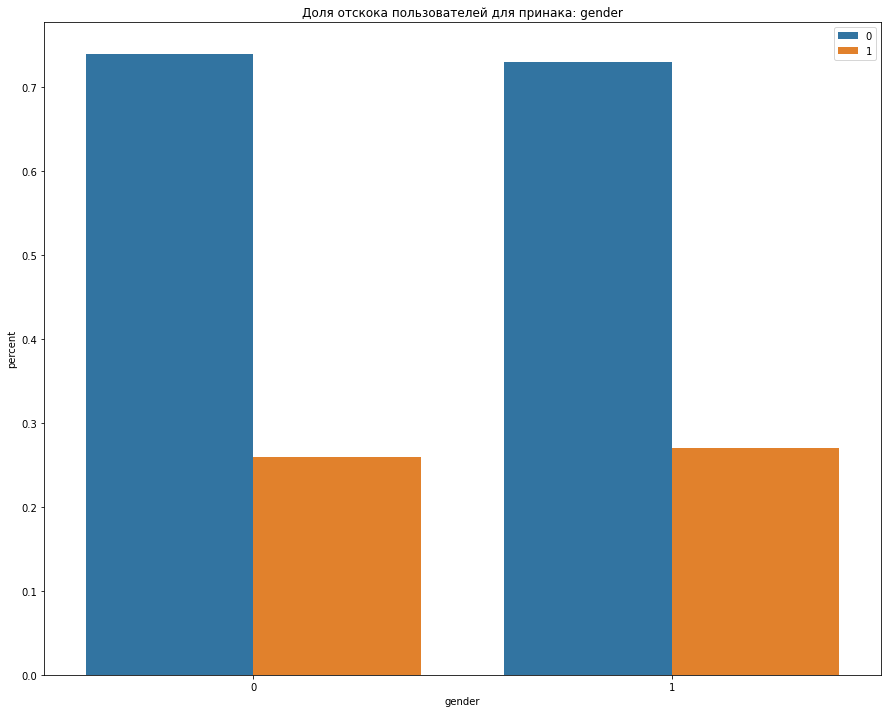


Таблица оттока для признака: near_location


,near_location,churn,churn_for_hist,percent
0,0,0,373,0.60
1,0,1,246,0.40
2,1,0,2566,0.76
3,1,1,815,0.24


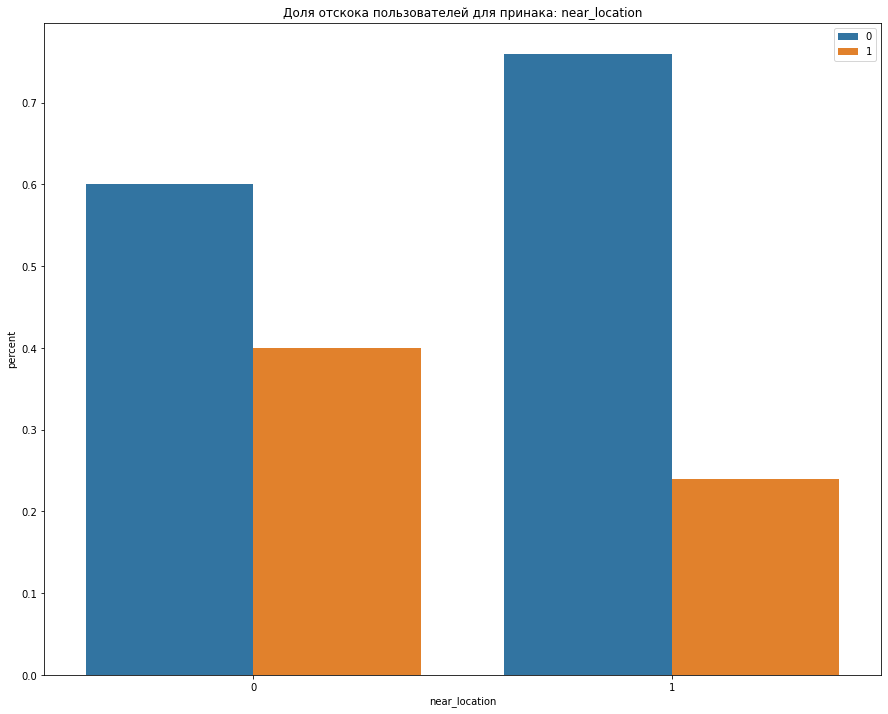


Таблица оттока для признака: partner


,partner,churn,churn_for_hist,percent
0,0,0,1369,0.67
1,0,1,684,0.33
2,1,0,1570,0.81
3,1,1,377,0.19


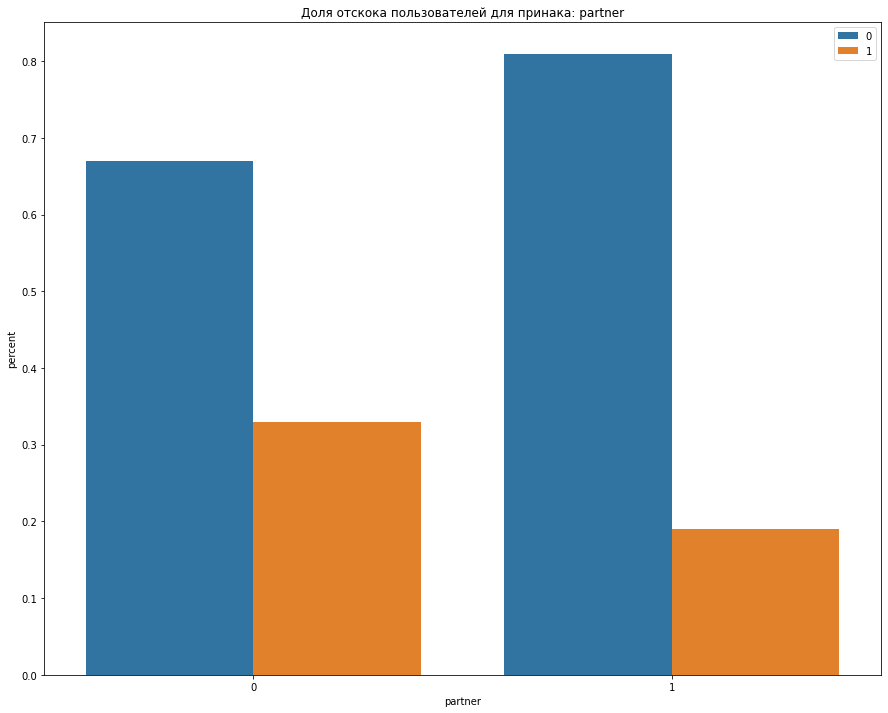


Таблица оттока для признака: promo_friends


,promo_friends,churn,churn_for_hist,percent
0,0,0,1900,0.69
1,0,1,866,0.31
2,1,0,1039,0.84
3,1,1,195,0.16


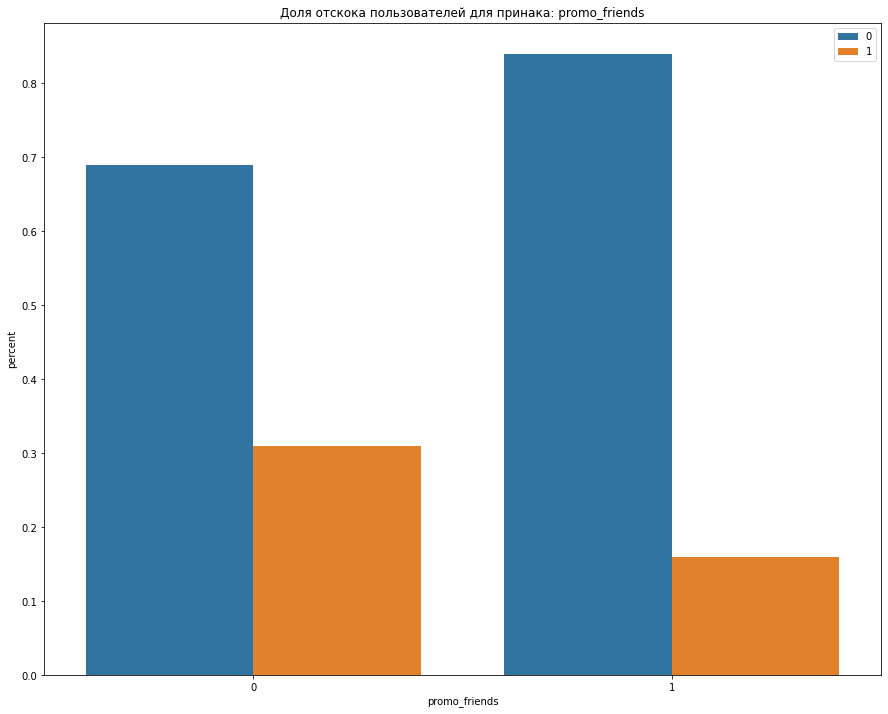


Таблица оттока для признака: phone


,phone,churn,churn_for_hist,percent
0,0,0,283,0.73
1,0,1,103,0.27
2,1,0,2656,0.73
3,1,1,958,0.27


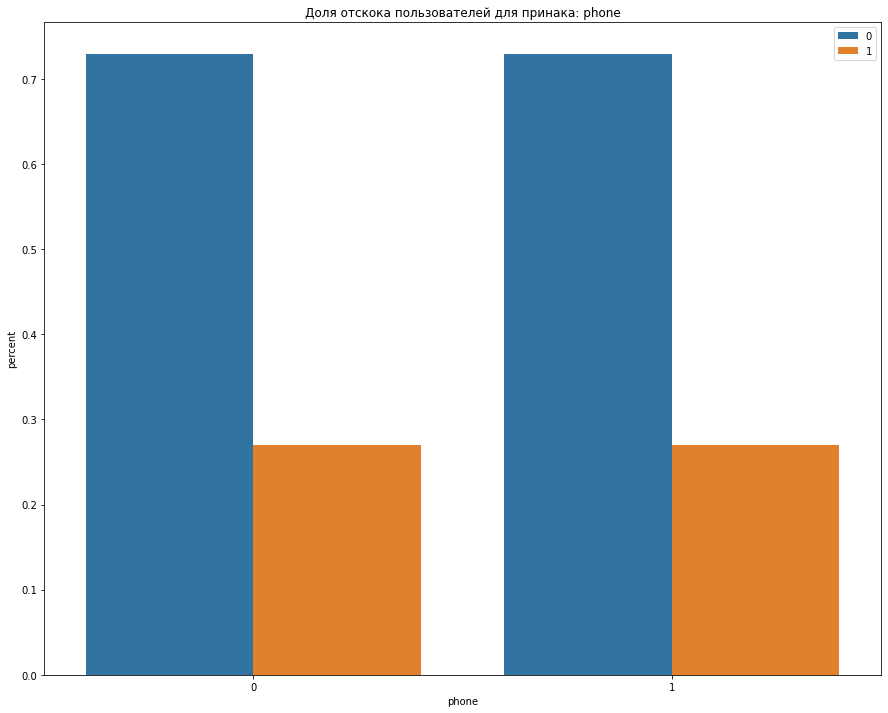


Таблица оттока для признака: contract_period


,contract_period,churn,churn_for_hist,percent
0,1,0,1273,0.58
1,1,1,934,0.42
2,6,0,729,0.88
3,6,1,104,0.12
4,12,0,937,0.98
5,12,1,23,0.02


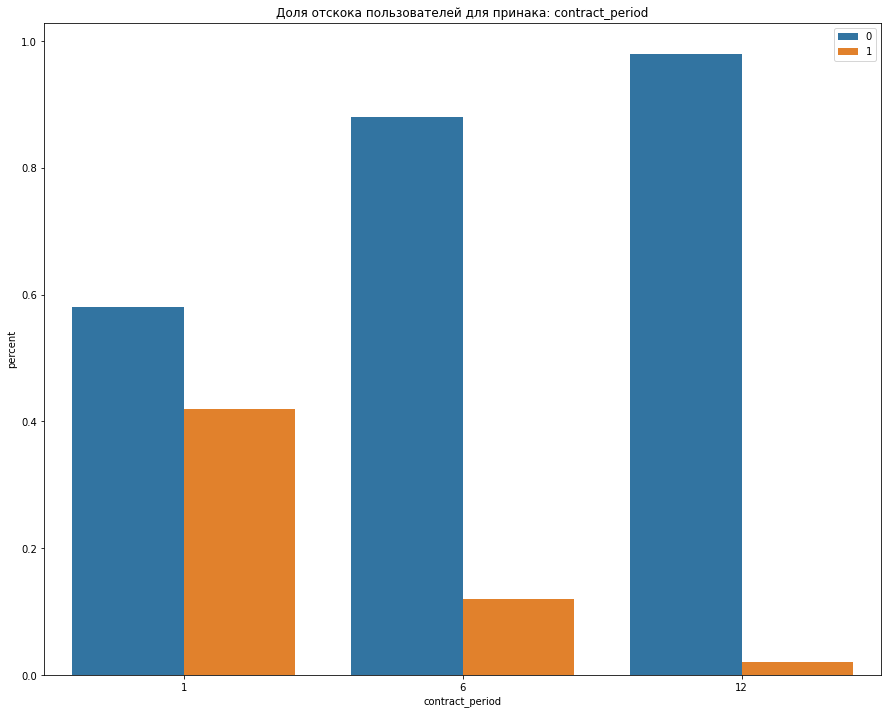


Таблица оттока для признака: group_visits


,group_visits,churn,churn_for_hist,percent
0,0,0,1575,0.67
1,0,1,776,0.33
2,1,0,1364,0.83
3,1,1,285,0.17


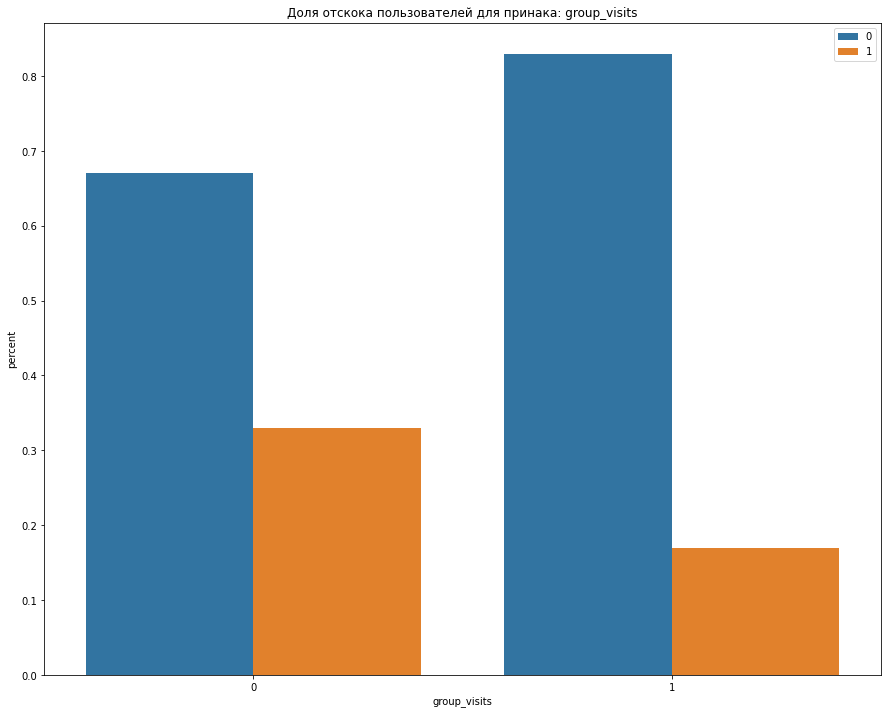

In [36]:
#вызываем полученные функции
histograms(gym, sign, 15, 12)

Теперь мы можем делать выводы по полученным таблицам и графикам.

1) **Признак gender**

На первый взгляд мы можем заметить, что пол не влияет на отток клиентов. Клиенты гендера 0 чуть слабее уходили, чем клиенты гендера 1 - всего на 1%. Предварительно можно сделать вывод о том, что гендер не влияет на отток клиентов.

2) **Признак near_location**

Ситуация здесь немного изменилась. Мы видим, что среди пользователей, которые живут или работают не рядом с центром процент оттока выше и составляет около 40%, в то время, как этот показатель для пользователей другой когорты составляет около 24%. Разница в 16% представляется значительной.

3) **Признак partner**

Среди непартнерово клуба отток выше, чем среди партнеров. Для партнеров такой показатель составляет 19%, в то время как, для непартнеров - 33%.

4) **Признак promo_friends**

Для тех, кто пришел в центр не по приглашению друзей отток выше и составляет 31%, чем для тех, кого пригласили друзья - отток 16%.

5) **Признак phone**

Удивительно, но у тех, кто не указал свой телефон и тех, кто указал, одинаковая доля оттока. При всем при этом доля тех, кто телефон не указал примерно в 10 раз меньше, но отток одинаковый.

6) **Признак contract_period**

Отток для клиентов, которые купили абонемент на один месяц, отток составляет 42%. Клиенты, купившие абонемент на 6 месяцев уходили уже в меньшем количестве - 12%. Для годового же абонемента отток составляет всего 2%. На первый взгляд мы видим прямую связь - чем дольше срок абонемента клиента, тем выше вероятность того, что он отсанется с клубом. После одного месяца клиенты могут уйти, ничего не потеряв. После года или полугода они уходят по внешним причинам, которые можно назвать изменением обстоятельсв, не связанных с работой клуба. Однако это только предположение.

7) **Признак group_visits**

Клиенты с групповыми занятиями уходили реже, чем те, у кого их не было. Отток для клиентов без групповых занятий - 33%, а для фанатов групп - всего 17%.

**Подводя итог**, можно сказать, что вырисовываются кое-какие зависимости, но это может быть только видимость. Нужно дальше анализировать.

Теперь приступим к построению распределений признаков. Также построим собственную функцию.

In [37]:
#создаем собственную функцию для построения графиков распределения
#задаем 4 входные перменные - таблицу, список, размер таблицы по горизонтали и вертикали, количество ячеек
def distribution(gym, quality, size_x, size_y, binss):
    #разделим датасет на 2 группы - для тех, кто поддался собзану уйти и для тех, что решил не уходить
    df_ch_0 = gym.query('churn ==0')
    df_ch_1 = gym.query('churn ==1')
    #цикл для перебора количественных признаков
    for k in quality:
        #визуализируем графики распределения так, чтобы графики для одного признака расположились на одной плоскости
        print(color.BOLD +'Распределение оттока для признака:', k + color.END)
        plt.figure(figsize=(size_x, size_y))
        sns.distplot(df_ch_0[k], bins = binss, label = 'churn =0') 
        sns.distplot(df_ch_1[k], bins = binss, label = 'churn =1') 
        plt.legend()
        plt.show()

Распределение оттока для признака: age


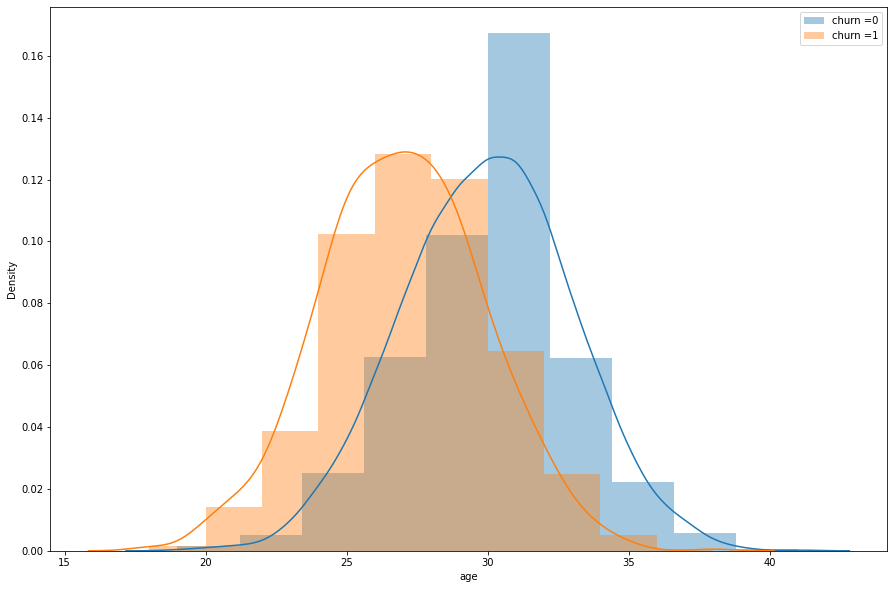

Распределение оттока для признака: avg_additional_charges_total


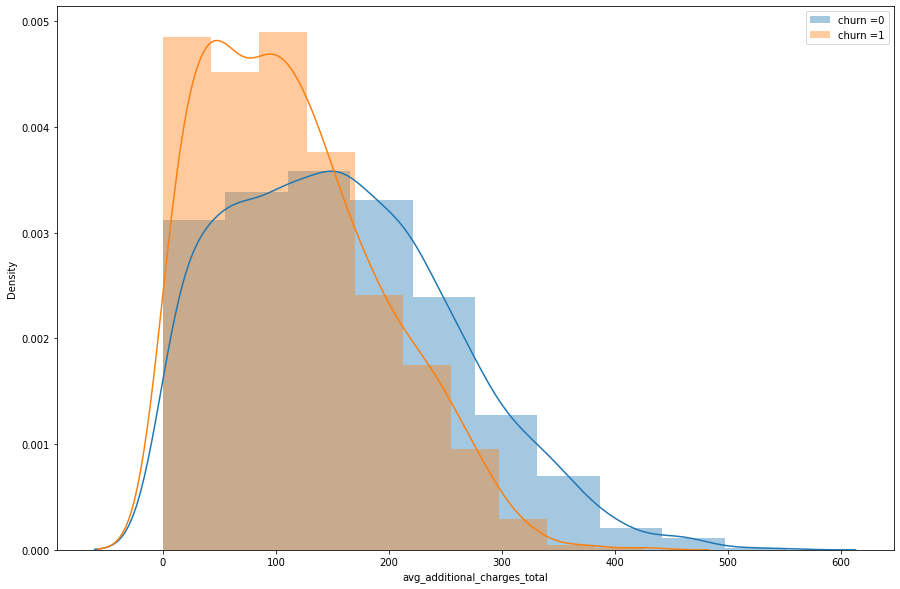

Распределение оттока для признака: month_to_end_contract


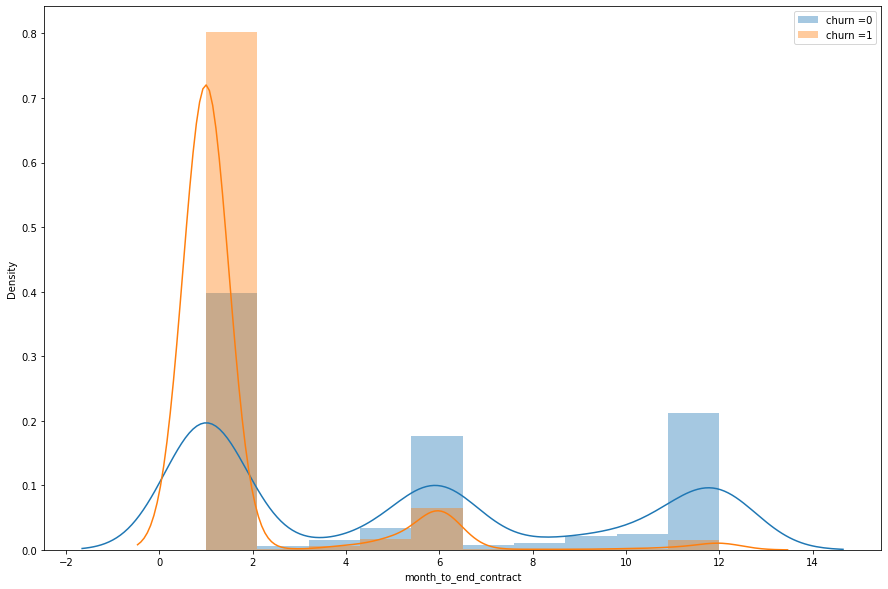

Распределение оттока для признака: lifetime


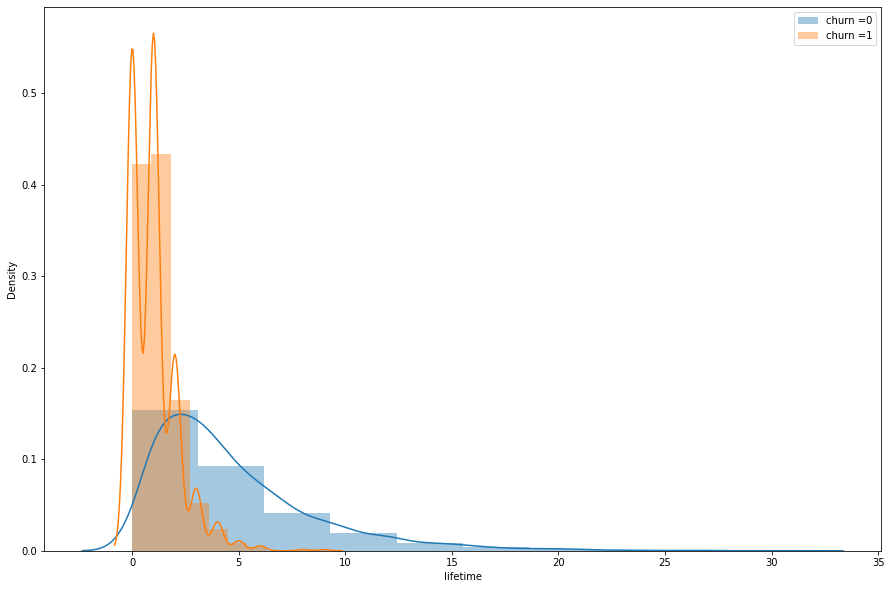

Распределение оттока для признака: avg_class_frequency_total


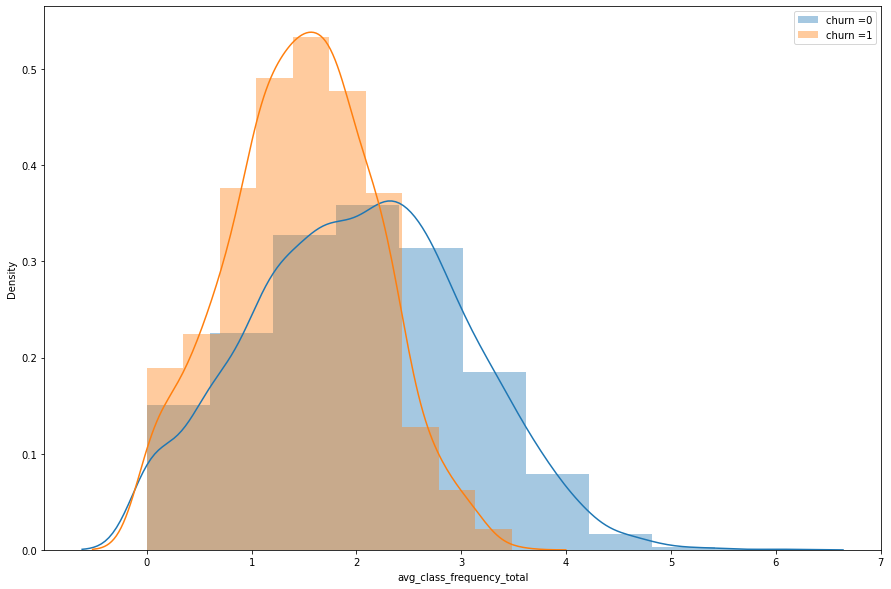

Распределение оттока для признака: avg_class_frequency_current_month


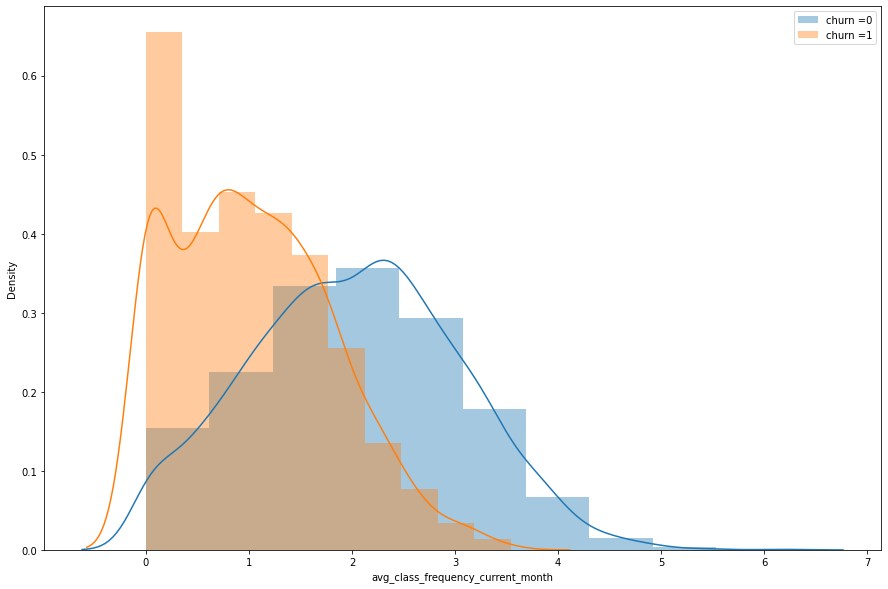

In [38]:
#вызываем полученные функции
distribution(gym, quality, 15, 10, 10)

Теперь приступим к анализу визуализаций.

1) **Признак age**

Мы видим, что наиболее подвержены оттоку клиенты в возрасте от 25 до 30 лет. Среди клиентов, которые не подвержены оттоку, больше всех тех, кто находился в возрасте от 30 до 33 лет. Мы видим, что, чем старше клиент, тем меньше вероятность того, что клиент отпадет. Мы видим, что до 30 лет больше клиентов, которые отпали, однако после 30 лет количество оставшихся клиентов стало превышать количество ушедших.

2) **Принзнак avg_additional_charges_total**

Заметно такое явление: чем больше, траты на дополнительные услуги, тем реже пользователи уходили из центра. Среди тех, кто потратил от 0 до 100 у.е. намного больше тех, кто ушел. Начиная от 150 у.е. количество отсавшихся клиентов стало превышать ушедших.

3) **Принзнак month_to_end_contract**

Мы видим, что лишь в одном случае отток пользователей превышает количетсво оставшихся - когда до окончания абонемента пользователя остается лишь месяц. В остальных же случаях - чем выше срок до окончания абонемента, тем больше разница между ушедшими и оставшимися в пользу оставшихся.

4) **Принзнак lifetime**

Тут все примерно так же, как и в прошлых наблюдениях, но куда более явно. Если время с момента первого обращения в фитнес-центр составляет от 0 до 3 месяцев, то чаще всего пользователи попадали в отток. Если лайфтайм составляет более 3 месяцев, то пользователи практически не уходили. Разница между churn=0 и churn=1 довольно значительная. Пользователи с лайфтаймом более 3 месяцев практически не уходили.

5) **Признак avg_class_frequency_total**

Заметно, что средняя частота посещений в неделю за все время с начала действия абонемента для тех, кто попал в отток и тех, кто не попал, различается. Мы видим, что те, кто посещал фитнес-центр в среднем в неделю около 2 раз, больше клиентов, попавших в отток. Те же, кто посещал центр больше 2 раз в неделю, чаще всего попадали в категорию тех, кто не уходил. Клиенты, посещавшие занятия более 3 раз в неделю либо вообще не уходили, либо крайне редко уходили.

6) **Признак avg_class_frequency_current_month**

Если клиент посещал клуб в прошлом месяце 0-1 раз в неделю, то  скорее всего он отпадет. Если же он посещал более 2 раз в неделю, то скорее всего он останется с клубом. Если он посещал более 4 раз в неделю, то он либо точно останется, либо крайне высока вероятность, что он останется.

С помощью построенных графиков мы смогли провести анализ и сделать первоначальные выводы о возможной зависимости между отток клиентов и признаками, характерными для этих клиентов. Однако это лишь первоначальный этап анализа. Чтобы выяснить, есть ли какие-либо зависимости между признаками и фактом оттока клиентов, **построим матрицу корреляции** и визуализируем ее.

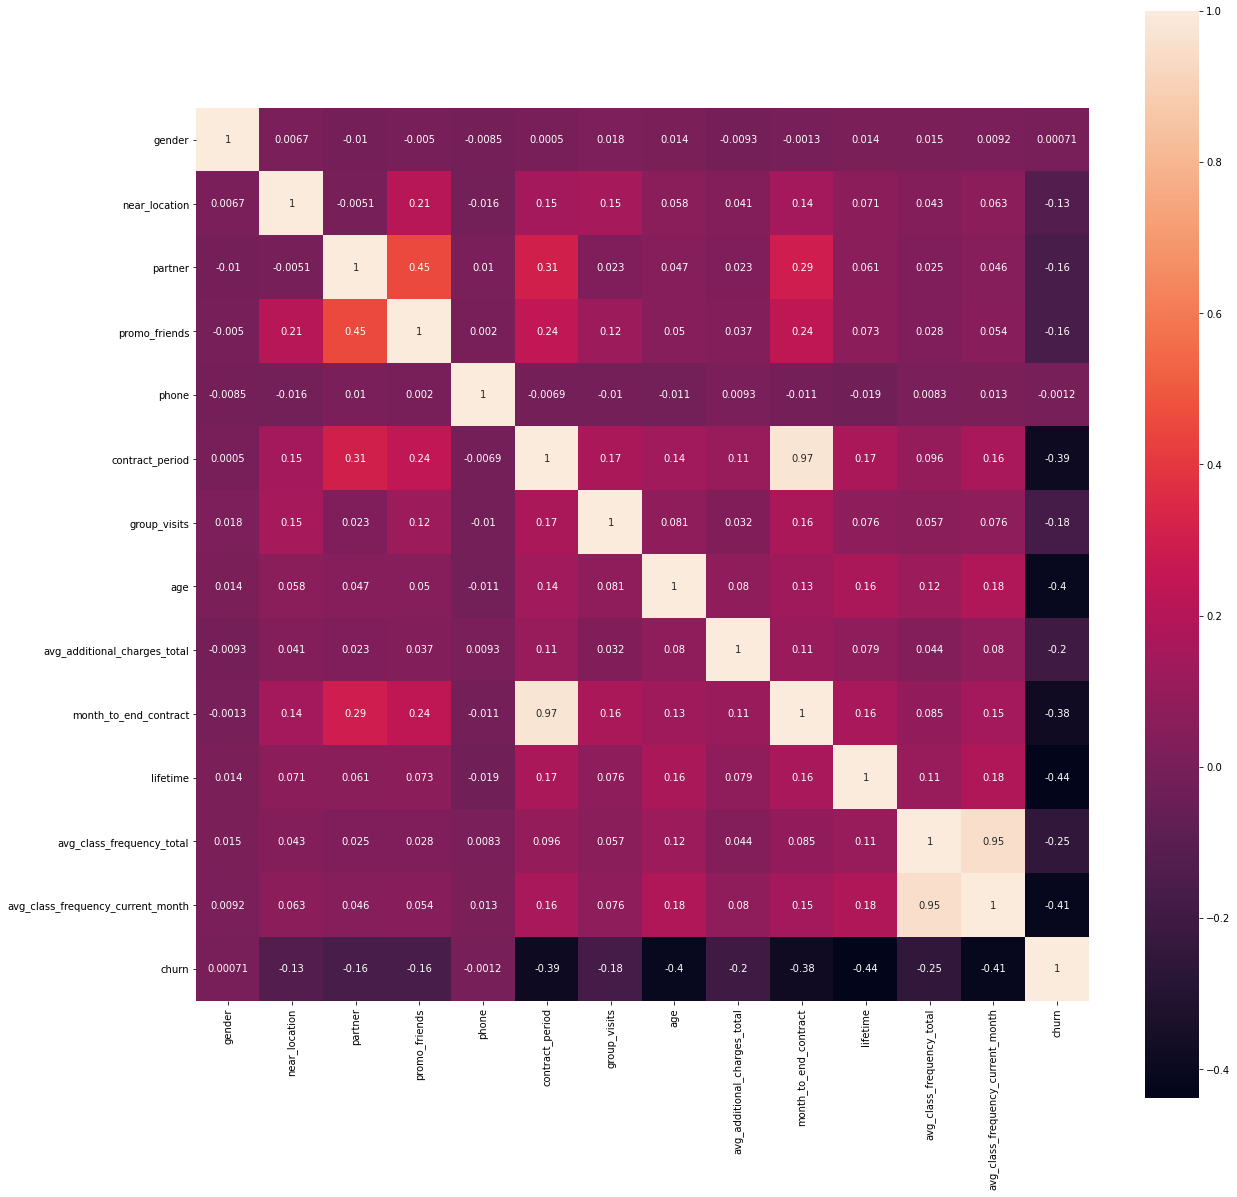

In [39]:
#создаем корреляционную матрицу
corr_m = gym.corr()
#определяем размер
plt.figure(figsize = (20,20))
# нарисуем heatmap
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

In [40]:
#выведем матрицу корреляции
corr_m

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


Что мы видим? Судя по матрице корреляций, нет признаков, с высокой вероятностью сообщающих правильный ответ. Можно лишь выделить некоторые из них, среди которых есть небольшая зависимость. Отток пользователей **(churn)** имеет обратную зависимость с признаком действие абонемента **(contract_period)** - корреляция для них составляет **-0.39**, возрастом **(age)** с корреляцией **-0.4**, временем окончания абонемента **(month_to_end_contract)** с корреляцией **-0.38**, лайфтаймом **(lifetime)** с корреляцией **-0.44**, средненедельном посещенеии центра в прошлом месяце **(avg_class_frequency_current_month)** с корреляцией **-0.41**. Так, чем выше одна из зависимых величин, тем ниже другая. Однако мы видим, что ни один из признаков не коррелируется с отток выше корреляции в 0.5, что говорит о безусловном наличии зависимости между признаками и целевой переменной, однако зависимость эта не слишком сильная.

Зато есть пары скоррелированных признаков: 
первая пара: **'month_to_end_contract'**  и **'contract_period'**. Корреляция у данных признаков равна **0.97**, что крайне велико.
вторая пара: **'avg_class_frequency_total'** и **'avg_class_frequency_current_month'**. У них корреляци признаков равна **0.95**, что крайне велико.



Нам нужно будет избавиться от мультиколлинеарности признаков. Сделать это нужно будет также и для машинного обучения. Оставим из двух зависимых признаков один. Оставим **contract_period**, поскольку корреляция между данным признаком и целевой переменной выше, а также потому, что данная переменная является более практичной и показательной. ТАкже оставим переменную **avg_class_frequency_current_month**, поскольку корреляция между признаком и целевой переменной выше. Сделаем это на следующем шаге.


# Шаг 3. Построим модель прогнозирования оттока клиентов


Для начала мы разобьем данные на две части: целевая переменная и признаки, которые могут влиять на нее. Целевой переменной выступает значение столбца **'churn'**. Также удалим и признаки, которые можно назвать мультиколлинеарными.

In [41]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(['churn',  'avg_class_frequency_total',  'month_to_end_contract'], axis=1)
y = gym['churn']

Теперь мы можем поделить данные на обучающую и валидационную выборку функцией train_test_split(). Так мы сможем обучить нашу модель и проверить эффективность ее работы.

In [42]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=0
)

Теперь нам предстоит стандартизировать данные c помощью функции StandardScaler. Так, мы сможем привести данные к единому стандарту так, чтобы наша модель могла наиболее качетсвенно сделать прогноз.

In [43]:
# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Теперь нам предстоит обучить модель на train-выборке двумя способами. Начнем с логистической регресии.

In [44]:
# зададим алгоритм для нашей модели
model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test_st)

Теперь построим модель случайного леса.

In [45]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state=0) 
# обучим модель
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
y_pred = rf_model.predict(X_test_st) 

Теперь построим собственную функцию для получения метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

In [62]:
#собственная функция по получению метрик
def metrics(y_test, y_pred):
    #метрики для логистической регрессии
    print('Accuracy : {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

In [63]:
#метрики для логистической регрессии
print('Метрики для логистической регрессии:')
metrics(y_test, predictions)

Метрики для логистической регрессии:
Accuracy : 0.92
Precision: 0.85
Recall: 0.84


In [64]:
#метрики для случайного леса
print('Метрики для случайного леса:')
metrics(y_test, y_pred)

Метрики для случайного леса:
Accuracy : 0.91
Precision: 0.85
Recall: 0.77


Мы видим, что модели примерно работают одинаково.

Доля верно угаданных ответов из прогнозов **(Accuracy)** для двух моделей  практически равна и составляет 0.92 для регресии и 0.91 для леса, что довольно неплохой показатель.

Точность, которая нам говорит, какова доля правильных ответов только среди целевого класса **(Precision)** для модели логистической регрессии и для случайного леса одинакова и составляет 0.85.

Полнота, показывающая сколько реальных целевых показателей класса "1" мы смогли обнаружить с помощью модели **(Recall)** для логистической регрессии (0.84) выше, чем для случайного леса (0.77)

Так, Логистическая регрессия смогла найти больше верных целевых показателей класса "1", поскольку Recall выше, а по остальным показателям она либо равна либо лучше случайного леса.

В целом, модели довольно похожи, однако Логистическая регрессия побеждает в этой битве, как более надежная.


# Шаг 4. Сделаем кластеризацию клиентов

Перед проведением кластеризации мы разделим данные на целевую переменную и признаки (без удаления мультиколлинеарности признаков). Затем стандартизируем признаки.

In [49]:
# еще раз разделим наши данные на признаки 
X_new = gym.drop('churn', axis=1)

In [50]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X_new)

После разделения и стандартизации мы приступаем к следующему: строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму. На основании полученного графика предполагаем, какое количество кластеров можно выделить.

In [51]:
#строим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

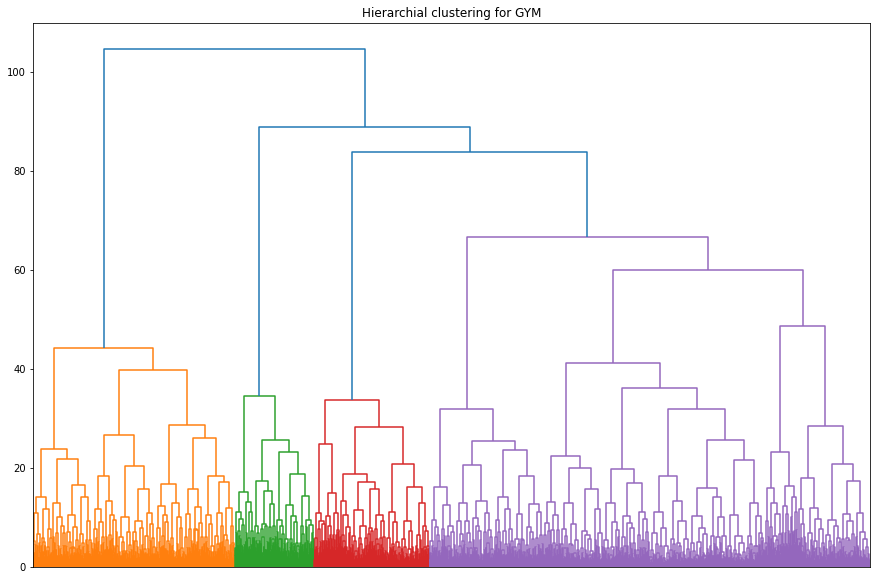

In [52]:
#рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Hierarchial clustering for GYM')
plt.show() 


Мы видим, что предложенное оптимальное число кластеров 4 — четыре разных цветов на графике. Однако, согласно ТЗ, нам необходимо поделить данные на 5 кластеров - видимо, для большей детализации. Так мы и поступим.

Теперь мы с помощью алгоритма K-Means спрогнозируем кластеры клиентов.

In [53]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

Мы спрогнозировали возможные кластеры. Теперь нам предстоит добавить столбец с кластером для каждого клиента.

In [54]:
# сохраняем метки кластера в поле нашего датасета
gym['cluster'] = labels

In [55]:
# выводим статистику по средним значениям наших признаков по кластеру
gym.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Клиенты кластеров 0 и 4 практически не подвержены оттоку. Кластеры 2 и 3 чаще всего уходят.

Для большей наглядности визуализируем признаки. Немного видоизменим наши функции, чтобы визуализация опиралась на кластеры, а не на отток.

In [56]:
#создаем собственную функцию для построения таблиц распределения признаков и их визуализации
#задаем 4 входные перменные - таблицу, список, размер таблицы по горизонтали и вертикали
def histograms2(gym, sign, size_x, size_y):
    #создаем таблицу для работы
    gym_hist = gym.copy()
    #создаем дополнительный столбец с данными об кластерах, чтобы при группировке мы не потеряли данные
    gym_hist['cluster_for_hist'] = gym_hist['cluster']
    #создаем цикл для каждого признака из списка, чтобы можно было строить датасет по каждому признаку
    for e in sign:
        #группируем таблицу по признаку и кластеру, считая количество клиентов для каждой группы
        gym_for_sign = gym_hist.groupby(['cluster', e], as_index=False)['cluster_for_hist'].count()
        #создаем столбец для записи туда процентов и заполняем его случайным числом - пусть будет единица
        gym_for_sign['percent'] = 1
        #переводим значения типа столбца в тип float, чтобы можно было получить проценты
        gym_for_sign['percent'] = gym_for_sign['percent'].astype('float')
        #строим еще один цикл для работы с ячейками, где переменная будет принимать номер строки
        for x in range(len(gym_for_sign)):
            #строим цикл, где переменная будет принимать уникальное значение качественной переменной.
            #можно было бы обойтись без этого шага, но так мы автоматизировали функцию
            for g in gym['cluster'].unique():
                #если значение ячейки полученных групп равно одному из уникальных значений
                if gym_for_sign['cluster'][x] ==g:
                    #то мы рассчитываем переменную, в которую войдет общее количество клиентов группы, а затем уже находим доли
                    c = gym_for_sign.groupby('cluster')['cluster_for_hist'].sum()
                    gym_for_sign['percent'][x] = round(gym_for_sign['cluster_for_hist'][x]/c[g], 2)
                else:
                    #в противном случае оставляем переменную без изменения
                    gym_for_sign['percent'][x] = gym_for_sign['percent'][x]
        #выводим полученные таблицы
        print('')
        print(color.BOLD +'Таблица оттока для признака:', e + color.END)
        display(gym_for_sign)
        print('')
        #определяем размер таблицы
        plt.figure(figsize=(size_x, size_y))
        #визуализируем!
        sns.barplot(x='cluster', y='percent', hue= e, data=gym_for_sign) 
        #указываем легенды
        plt.legend()
        #указываем заглавие
        plt.title(f'Доля пользователей по кластерам для принака: {e}')
        plt.show()

In [57]:
#создадим новый список и добавим туда уже целевую перменную
sign2 =['gender','near_location', 'partner','promo_friends','phone','contract_period','group_visits', 'churn']


Таблица оттока для признака: gender


,cluster,gender,cluster_for_hist,percent
0,0,0,502,0.50
1,0,1,508,0.50
2,1,0,184,0.48
3,1,1,201,0.52
4,2,0,255,0.50
5,2,1,250,0.50
6,3,0,649,0.51
7,3,1,613,0.49
8,4,0,369,0.44
9,4,1,469,0.56


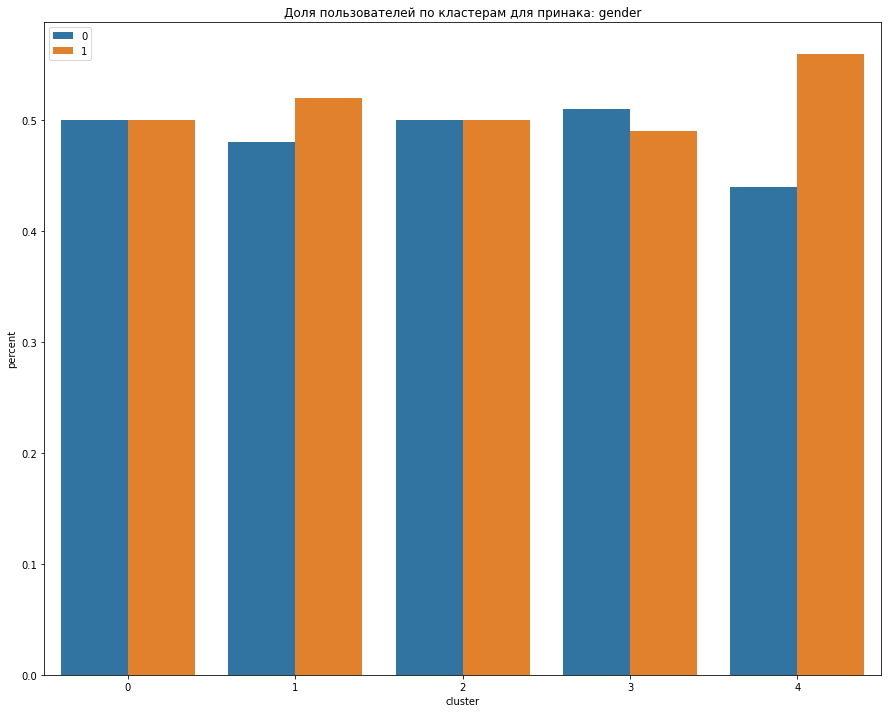


Таблица оттока для признака: near_location


,cluster,near_location,cluster_for_hist,percent
0,0,0,41,0.04
1,0,1,969,0.96
2,1,0,53,0.14
3,1,1,332,0.86
4,2,0,505,1.00
5,3,1,1262,1.00
6,4,0,20,0.02
7,4,1,818,0.98


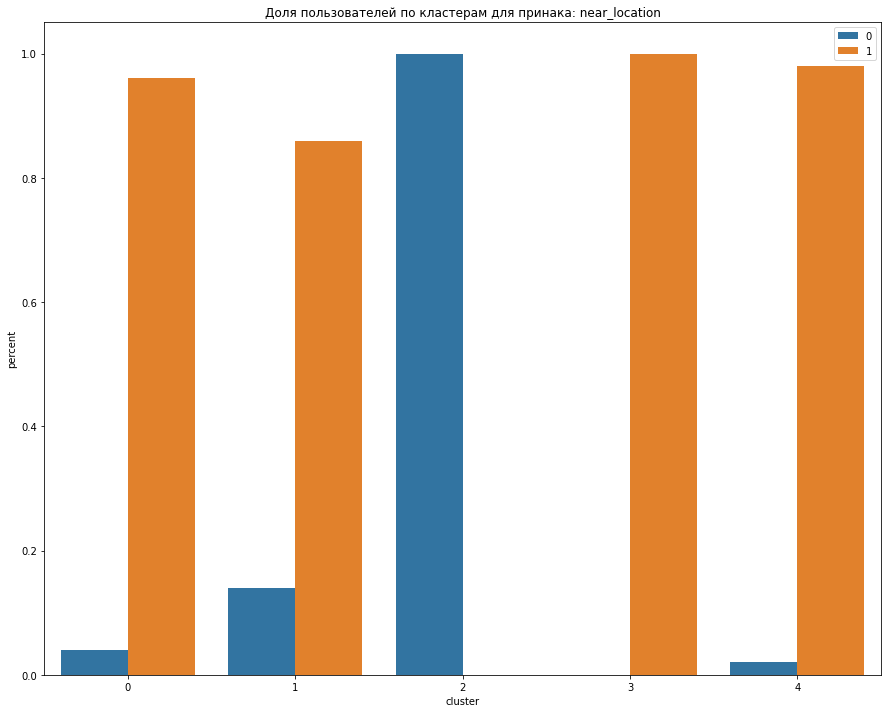


Таблица оттока для признака: partner


,cluster,partner,cluster_for_hist,percent
0,0,0,219,0.22
1,0,1,791,0.78
2,1,0,204,0.53
3,1,1,181,0.47
4,2,0,271,0.54
5,2,1,234,0.46
6,3,0,820,0.65
7,3,1,442,0.35
8,4,0,539,0.64
9,4,1,299,0.36


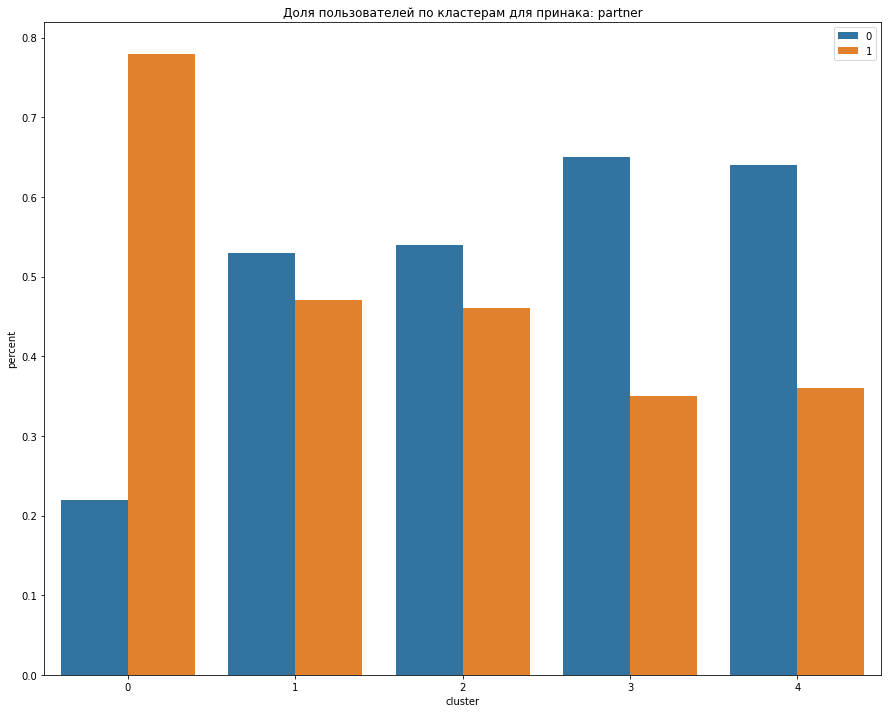


Таблица оттока для признака: promo_friends


,cluster,promo_friends,cluster_for_hist,percent
0,0,0,430,0.43
1,0,1,580,0.57
2,1,0,267,0.69
3,1,1,118,0.31
4,2,0,465,0.92
5,2,1,40,0.08
6,3,0,959,0.76
7,3,1,303,0.24
8,4,0,645,0.77
9,4,1,193,0.23


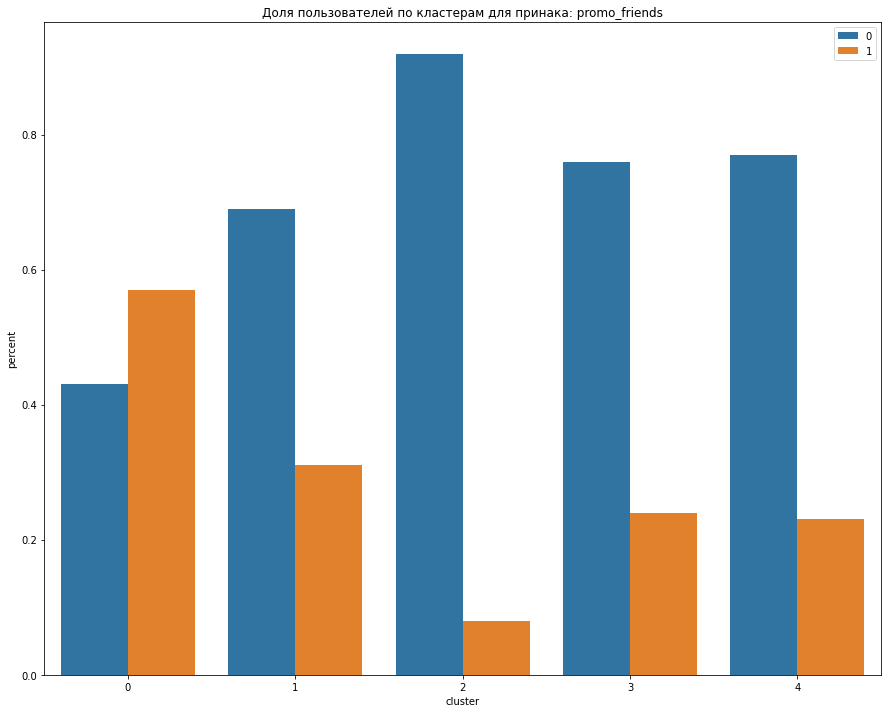


Таблица оттока для признака: phone


,cluster,phone,cluster_for_hist,percent
0,0,1,1010,1.0
1,1,0,385,1.0
2,2,1,505,1.0
3,3,1,1262,1.0
4,4,0,1,0.0
5,4,1,837,1.0


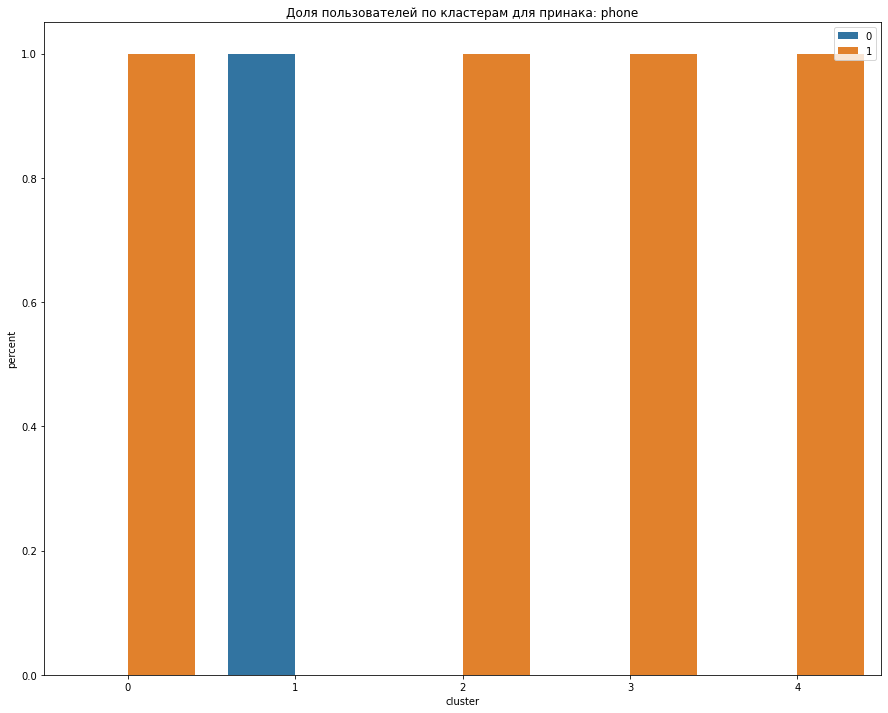


Таблица оттока для признака: contract_period


,cluster,contract_period,cluster_for_hist,percent
0,0,6,187,0.19
1,0,12,823,0.81
2,1,1,205,0.53
3,1,6,87,0.23
4,1,12,93,0.24
5,2,1,390,0.77
6,2,6,97,0.19
7,2,12,18,0.04
8,3,1,1031,0.82
9,3,6,224,0.18


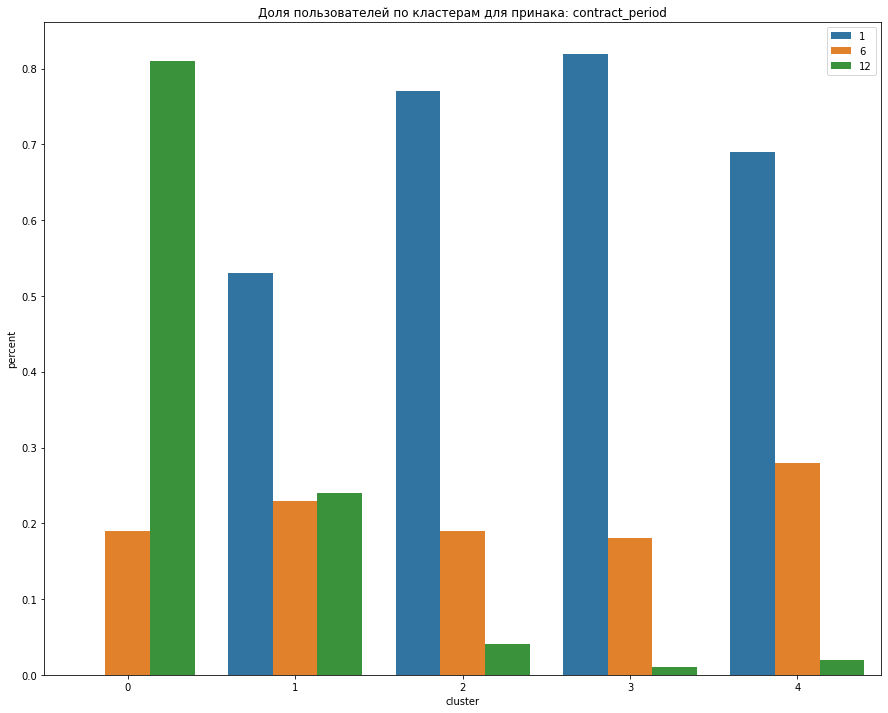


Таблица оттока для признака: group_visits


,cluster,group_visits,cluster_for_hist,percent
0,0,0,462,0.46
1,0,1,548,0.54
2,1,0,221,0.57
3,1,1,164,0.43
4,2,0,396,0.78
5,2,1,109,0.22
6,3,0,831,0.66
7,3,1,431,0.34
8,4,0,441,0.53
9,4,1,397,0.47


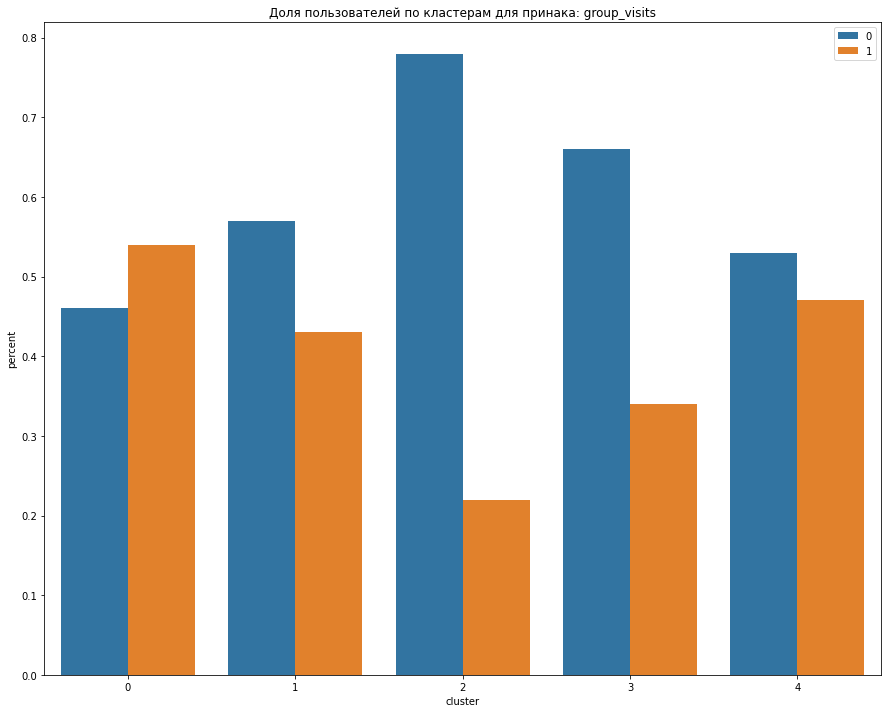


Таблица оттока для признака: churn


,cluster,churn,cluster_for_hist,percent
0,0,0,982,0.97
1,0,1,28,0.03
2,1,0,282,0.73
3,1,1,103,0.27
4,2,0,281,0.56
5,2,1,224,0.44
6,3,0,613,0.49
7,3,1,649,0.51
8,4,0,781,0.93
9,4,1,57,0.07


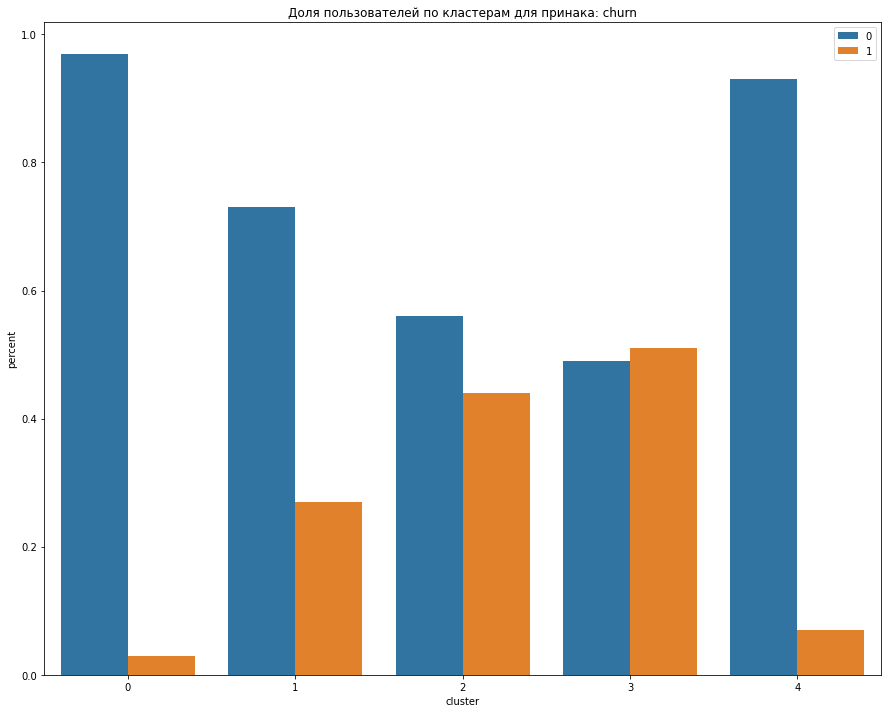

In [58]:
#вызываем функцию
histograms2(gym, sign2, 15, 12)

In [59]:
#создаем собственную функцию для построения графиков распределения
#задаем 4 входные перменные - таблицу, список, размер таблицы по горизонтали и вертикали, количество ячеек
def distribution_2(gym, quality, size_x, size_y, binss):
    #разделим датасет на 5 групп по кластерам
    df_cl_0 = gym.query('cluster ==0')
    df_cl_1 = gym.query('cluster ==1')
    df_cl_2 = gym.query('cluster ==2')
    df_cl_3 = gym.query('cluster ==3')
    df_cl_4 = gym.query('cluster ==4')
    #цикл для перебора количественных признаков
    for k in quality:
        #визуализируем графики распределения так, чтобы графики для одного признака расположились на одной плоскости
        print(color.BOLD +'Распределение оттока для признака:', k + color.END)
        plt.figure(figsize=(size_x, size_y))
        sns.distplot(df_cl_0[k], bins = binss, label = 'cluster =0') 
        sns.distplot(df_cl_1[k], bins = binss, label = 'cluster =1') 
        sns.distplot(df_cl_2[k], bins = binss, label = 'cluster =2') 
        sns.distplot(df_cl_3[k], bins = binss, label = 'cluster =3') 
        sns.distplot(df_cl_4[k], bins = binss, label = 'cluster =4') 
        plt.legend()
        plt.show()

Распределение оттока для признака: age


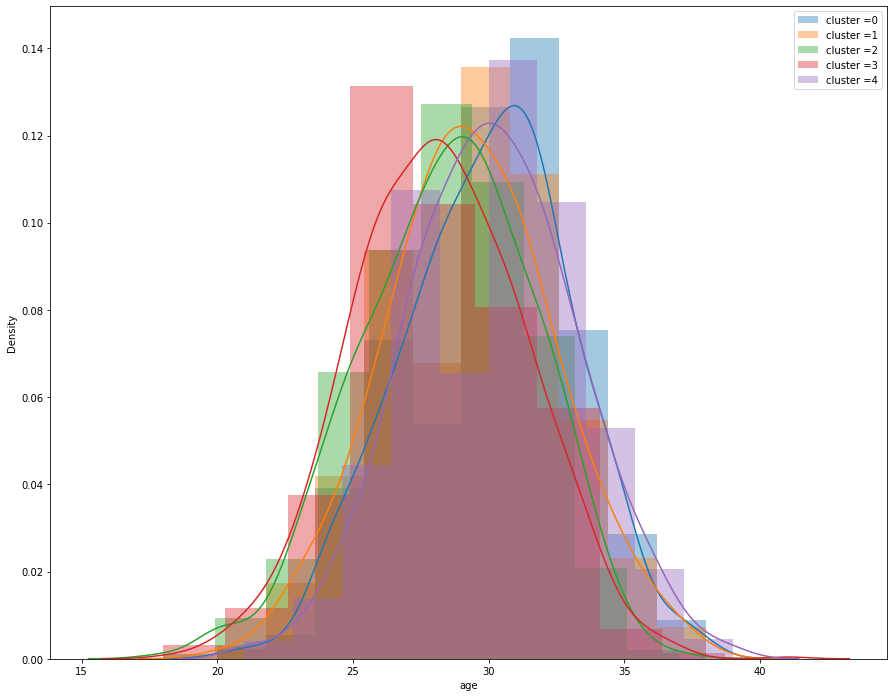

Распределение оттока для признака: avg_additional_charges_total


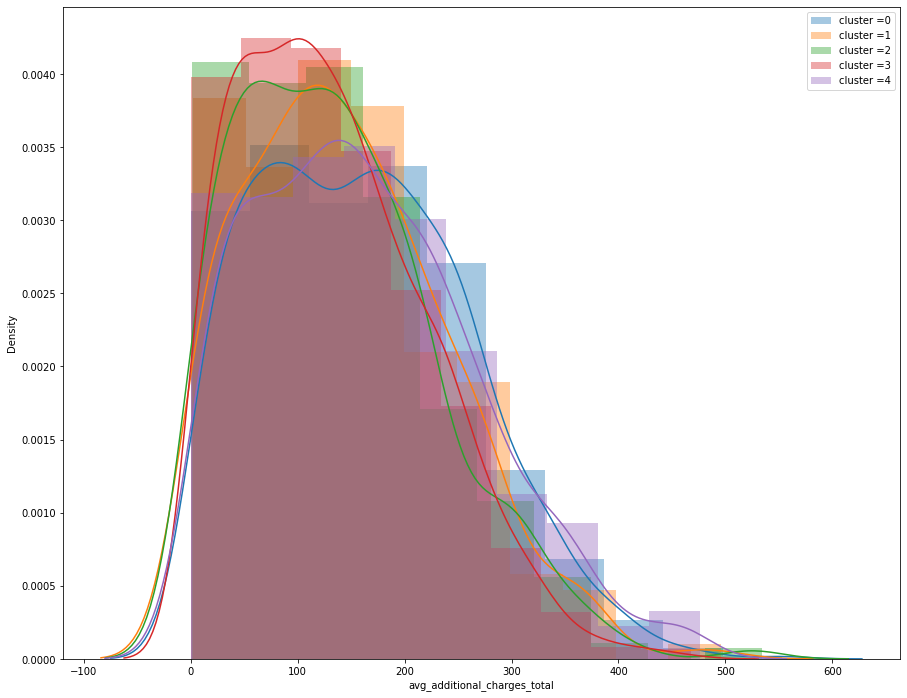

Распределение оттока для признака: month_to_end_contract


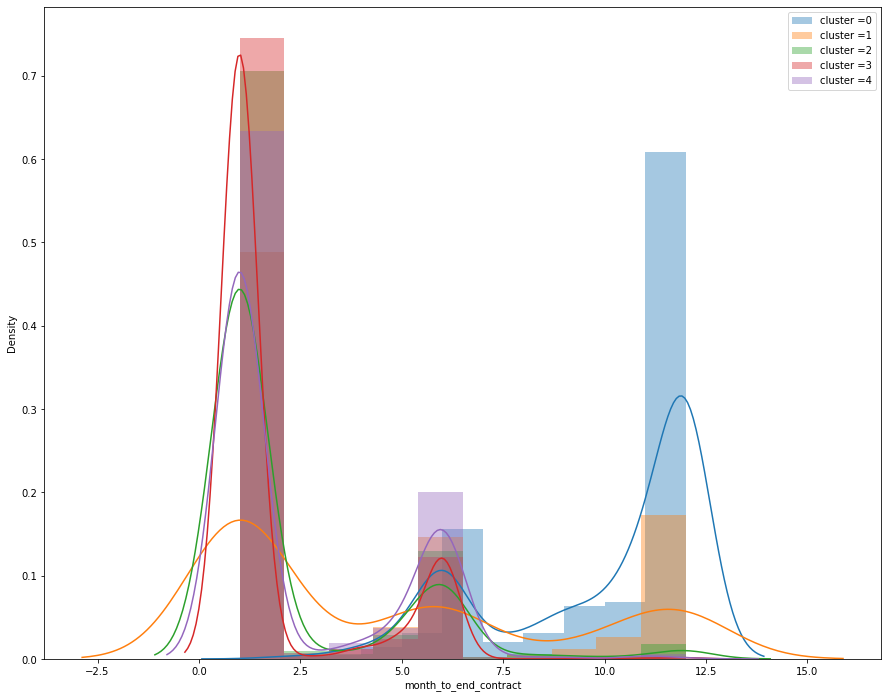

Распределение оттока для признака: lifetime


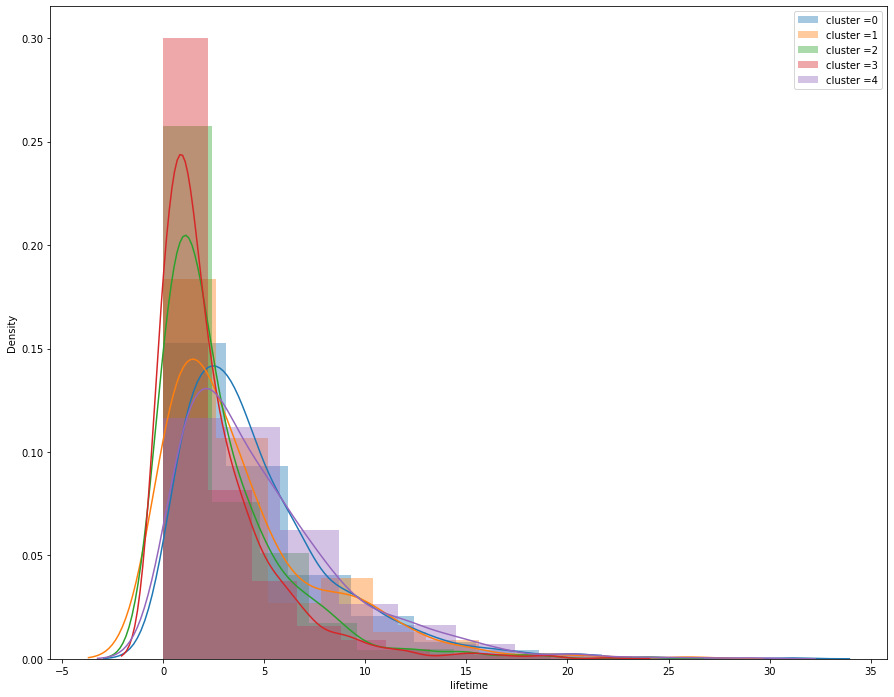

Распределение оттока для признака: avg_class_frequency_total


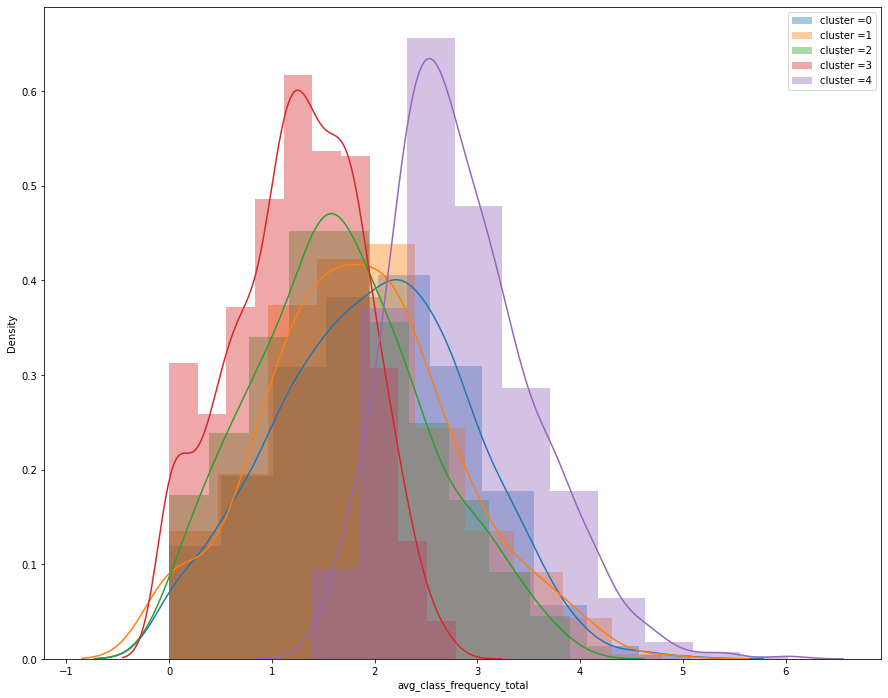

Распределение оттока для признака: avg_class_frequency_current_month


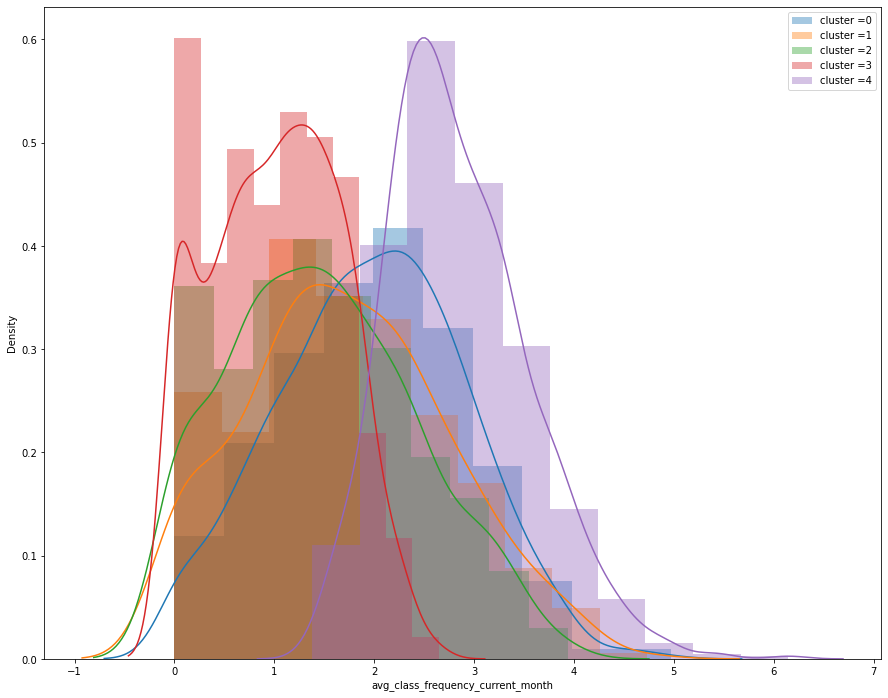

In [60]:
#применяем новую функцию
distribution_2(gym, quality, 15, 12, 10)

Графикик подтвердили наши наблюдения.

Мы видим средние значения признаков для кластеров.

**Кластер 0:**

* одинаковое количество мужчин и женщин
* практически все клиенты жили или работали рядом с центром
* 80% клиентов были партнерами клиента
* чуть больше половины клиентов были приглашены друзьями
* все клиенты оставили мобильный
* среднее время действия абонемента - 11 месяцев
* примерно половина клиентов посещала групповые занятия
* средний возраст - 30 лет
* средние дополнительные траты клиентов на услуги -160 у.е.
* средний период до оокнчания абонемента - 10 месяцев
* лайфтайм - 4 месяца
* среднее общее недельное посещение занятий - 2
* среднее недельное посещение занятий в прошлом месяце - 2
* лишь 2% клиентов попали в отток

**Кластер 1:**

* одинаковое количество мужчин и женщин
* 86% клиентов жили или работали рядом с центром
* 47% клиентов были партнерами клиента
* 30% клиентов были приглашены друзьями
* никто из клиентов не оставил мобильный
* среднее время действия абонемента - 5 месяцев
* 43% клиентов посещала групповые занятия
* средний возраст - 30 лет
* средние дополнительные траты клиентов на услуги -144 у.е.
* средний период до оокнчания абонемента - 4 месяца
* лайфтайм - 4 месяца
* среднее общее недельное посещение занятий - 2
* среднее недельное посещение занятий в прошлом месяце - 2
* около 26% клиентов попали в отток


**Кластер 2:**

* одинаковое количество мужчин и женщин
* ни один клиент не жил или работал рядом с центром
* 46% клиентов были партнерами клиента
* 8% клиентов были приглашены друзьями
* все клиенты оставили мобильный
* среднее время действия абонемента - 2 месяца
* 22% клиентов посещала групповые занятия
* средний возраст - 28 лет
* средние дополнительные траты клиентов на услуги -135 у.е.
* средний период до оокнчания абонемента - 2 месяца
* лайфтайм - 3 месяца
* среднее общее недельное посещение занятий - 2
* среднее недельное посещение занятий в прошлом месяце - 1
* около 44% клиентов попали в отток


**Кластер 3:**

* одинаковое количество мужчин и женщин
* все клиенты жили или работали рядом с центром
* 35% клиентов были партнерами клиента
* 24% клиентов были приглашены друзьями
* все клиенты оставили мобильный
* среднее время действия абонемента - 2 месяца
* 34% клиентов посещала групповые занятия
* средний возраст - 28 лет
* средние дополнительные траты клиентов на услуги -132 у.е.
* средний период до оокнчания абонемента - 2 месяца
* лайфтайм - 2 месяца
* среднее общее недельное посещение занятий - 1
* среднее недельное посещение занятий в прошлом месяце - 1
* около 51% клиентов попали в отток


**Кластер 4:**

* одинаковое количество мужчин и женщин. Представителей гендера 1 на 6% больше.
* практически все клиенты жили или работали рядом с центром
* 36% клиентов были партнерами клиента
* 23% клиентов были приглашены друзьями
* практически все клиенты оставили мобильный
* среднее время действия абонемента - 3 месяца
* 47% клиентов посещала групповые занятия
* средний возраст - 30 лет
* средние дополнительные траты клиентов на услуги - 161 у.е.
* средний период до оокнчания абонемента - 2 месяца
* лайфтайм - 5 месяца
* среднее общее недельное посещение занятий - 3
* среднее недельное посещение занятий в прошлом месяце - 3
* около 6% клиентов попали в отток

Для каждого полученного кластера считаем отдельно долю оттока (методом groupby()). 

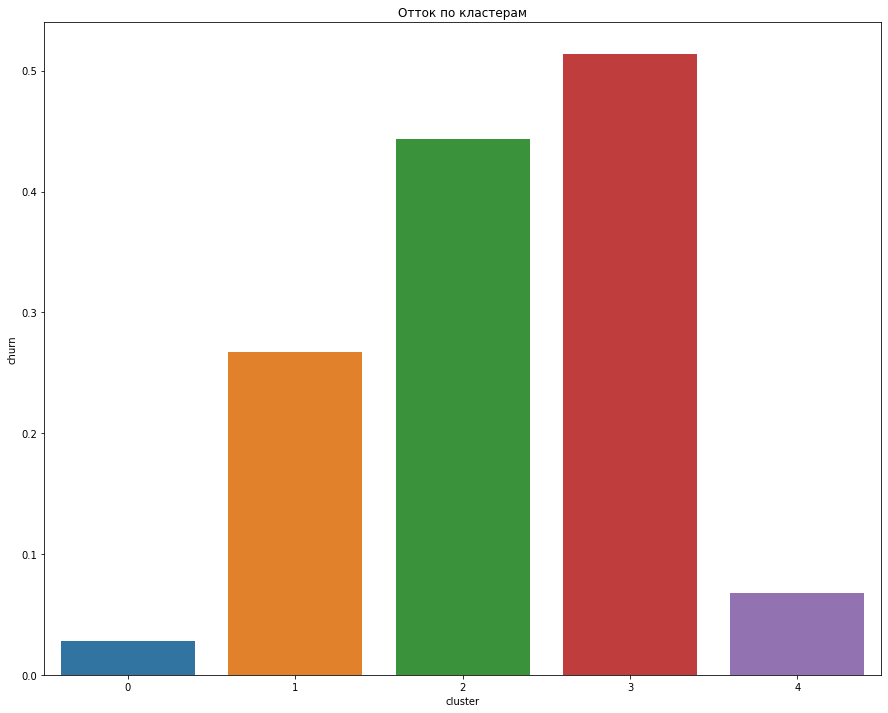

In [61]:
#группируем по кластерам
cl_gym = gym.groupby('cluster', as_index=False)['churn'].mean()
plt.figure(figsize=(15, 12))
#визуализируем!
sns.barplot(x='cluster', y='churn', data=cl_gym) 
#указываем заглавие
plt.title('Отток по кластерам')
plt.show()

Мы можем условно поделить кластеры на 3 группы по оттоку и выделить для каждой из групп наиболее характерные и общие признаки:
    
1) **отток до 10%:**
кластеры 0 и 4
* в прошлом месяце посещали минимум одно занятие, чаще всего 2-3 занятия в неделю.
* траты на доп.услуги в основном выше, чем у других кластеров
* чаще других посещали групповые занятия
* как правило, постарше

2) **отток от 10% до 30%**
кластер 1
* не оставили телефона
* значительный процент тех, кто не живет и не работает рядом с центром
* практически не посещали групповые занятия
* в целом данная группа повторяет некоторые признаки кластеров 2 и 3 и местами схожа с кластерами 0 и 4. Ее можно назвать переходной от одной группы к другой.

3) **отток от 30%**
кластеры 2 и 3
* чаще всего лайфтайм от 0 до 2
* меньше остальных посещали групповые занятия
* тратили меньше на доп.услуги, чем другие кластеры
* в основном посещали в прошлом месяце 0-2 занятия в неделю. Наиболее частый вариант - 1 занятие в неделю
* очень мало было клиентов по промокодам друзей
* как правило, помладше

Так мы можем понять, какие признаки наиболее важны для наших кластеров. 

# Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

Подводя итог, можем сделать некоторые выводы.
Меньше всего оттоку подвергались следующие клиенты:

**Во-первых**, те, кто `живет или работает рядом с фитнес-центром`. Это подверждает распределение признаков по оттоку и кластеры 0 и 4, которые подвержены оттоку меньше всего.

**Во-вторых**, те, кто `купил абонемент на срок более месяца.` Например, среди тех, кто взял абонемент на 12 месяцев, в отток попали всего 2%, среди тех, кто брал абонемент на полгода - 12%. Это подтверждается и признаком lifetime. Среди тех, кто был знаком с клубо более 5 месяцев, практически никто не уходил. 

**В-третьих**, те, кто `посещал групповые занятия` так же реже отпадают. Среди наименне уходящих кластеров 0 и 4 большое количество клиентов посещало групповые занятия. Так, среди тех, кто не ходил на групповые занятия, отпало 33%, а среди тех, кто хходил - 17%.

**В-четвертых**, те, кто `были старше 30 лет уходили` из центра реже, чем те, кто был моложе. Так, клиентов в возрасте после 30 лет осталось больше, чем тех, кто ушел.

**В-пятых**, те, кто `тратил на дополнительные услуги в фитнес-центре больше средних трат одного клиента.` Наименее уходящие кластеры так же тратили больше кластеров, которые тратили меньше.

**В-шестых**, те, кто `ходил в клуб в прошлом месяце больше 2 раз в неделю.` Это наблюдение подтверждается как кластерами, так и распределением признаков.

**В-седьмых**, те, `кто был привлечен в фитнес по партнерским программам` (промокоды от друзей или партнеры компаний). Это может быть связано с психологией человека - гораздо привлекательнее кажется услуга, когда она дается со скидкой.

Так, мы можем дать рекомендации фитнес-центру:

**1)** Привлекать лиц, которые живут или работают рядом с фитнес-клубом. Они наименее подвержены оттоку. Клиентам намного удобнее ходить в клуб, находящийся рядом с работой или домом, поскольку далеко идти не нужно.

**2)** Убеждать клиентов покупать абонементы не на 1 месяц, а на большие сроки - 6 месяцев и куда более желательно - год. Делать это можно с помощью различных скидок и иных акций.

**3)** Продвигать групповые занятия среди клиентов. С психологической точки зрения это приведет к тому, что клиенты могут завести новые знакомства, с которыми намного приятнее ходить в клуб. ТАк же они могут ходить на групповые занятия с друзьями. Ходить в зал с кем-либо намного интереснее, чем одному.

**4)** Активно продвигать услуги центра среди лиц, старше 30 лет, поскольку они чаще остаются с клубом надолго. Предлагать им скидки и акции, а также групповые занятия. Также необходимо сделать так, чтобы более молодые клиенты задерживались с клубом подольше - предлагать им абонементы на более длительные сроки или скидки и промо-коды для друзей.

**5)** Развивать сопутствующую инфраструктуру, делать ее более привлекательной для клиентов. Чем больше клиент тратит на доп.услуги в клубое, тем выше вероятность того, что он задержится в клубе.

**6)** Мотивировать клиентов посещать занятия чаще 1-2 раз в неделю. Можно это сделать с помощью скидки - при наборе определенного количества занятий в определенный срок, при покупке следующего абонемента можно получить скидку или промо-код со скидкой для друга.

**7)** Развитие партнерских программ. Все любят скидки. Скидка делает услугу более привлекательной. А если человек уже купит абонемент на срок более месяца, то вероятнее всего задержится с клубом. Главное, суметь привлечь его. Только промо-коды и и партнерские программы должны распространяться на абонементы сроком более месяца.